# Reproduce Final Submission - Full Training Pipeline

**Note:** This notebook was generated by Claude Code on behalf of Marco Cassar. The original training repository was provided to compile this notebook version for ease of access in Google Colab.

This notebook trains a VAE + Flow model from scratch following the exact pipeline:
1. Train VAE on MNIST
2. Save VAE with EMA weights
3. Encode MNIST dataset using trained VAE
4. Train flow model on encoded latents
5. Save flow model with EMA weights
6. Test generation

## Imports and Setup

In [1]:
!pip install wandb torch_ema

In [2]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torch_ema import ExponentialMovingAverage
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm
from safetensors.torch import save_file, load_file
import matplotlib.pyplot as plt
import wandb
from math import log2

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Model Definitions

In [3]:
# Copy all model classes from marco_submission_2.py
# ResidualBlock, InspoResNetVAEEncoder, InspoResNetVAEDecoder, InspoResNetVAE, FlatVelocityNet

class ResidualBlock(nn.Module):
    def __init__(self, channels, use_skip=True, use_bn=True, act=nn.GELU, dropout=0.4, groups=1):
        super().__init__()
        self.dropout = dropout
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1, bias=not use_bn, groups=groups)
        self.bn1 = nn.BatchNorm2d(channels) if use_bn else nn.Identity()
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1, bias=not use_bn, groups=groups)
        self.bn2 = nn.BatchNorm2d(channels) if use_bn else nn.Identity()
        self.use_skip, self.act = use_skip, act

    def forward(self, x):
        if self.use_skip: x0 = x
        out = self.act()(self.bn1(self.conv1(x)))
        out = F.dropout(out, self.dropout, training=self.training)
        out = self.bn2(self.conv2(out))
        if self.use_skip: out = out + x0
        return self.act()(out)

class InspoResNetVAEEncoder(nn.Module):
    def __init__(self, in_channels, latent_dim=3, base_channels=32, blocks_per_level=2, use_skips=True, use_bn=True,
                 act=nn.GELU, groups=1, dropout=0.4):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, base_channels, 3, padding=1, bias=not use_bn)
        self.bn1 = nn.BatchNorm2d(base_channels) if use_bn else nn.Identity()
        channels = [base_channels, base_channels * 2, base_channels * 4]
        self.levels = nn.ModuleList(
            [nn.ModuleList([ResidualBlock(ch, use_skips, use_bn, act=act, dropout=dropout, groups=groups) for _ in range(blocks_per_level)]) for ch in
             channels])
        self.transitions = nn.ModuleList(
            [nn.Conv2d(channels[i], channels[i + 1], 1, bias=not use_bn) for i in range(len(channels) - 1)])
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(base_channels * 4, 2 * latent_dim)
        self.act = act

    def forward(self, x):
        x = self.act()(self.bn1(self.conv1(x)))
        for i in range(len(self.levels)):
            if i > 0:
                x = F.avg_pool2d(x, 2)
                x = self.transitions[i - 1](x)
            for block in self.levels[i]:
                x = block(x)
        x = self.global_avg_pool(x)
        x = self.fc(x.flatten(start_dim=1))
        mean, logvar = x.chunk(2, dim=1)
        return mean, logvar

class InspoResNetVAEDecoder(nn.Module):
    def __init__(self, out_channels, latent_dim=3, base_channels=32, blocks_per_level=2, use_skips=True, use_bn=True,
                 act=nn.GELU, groups=1, dropout=0.4):
        super().__init__()
        channels = [base_channels, base_channels * 2, base_channels * 4][::-1]
        self.channels = channels
        self.start_dim = 7
        self.fc = nn.Linear(latent_dim, channels[0] * self.start_dim * self.start_dim)
        self.levels = nn.ModuleList(
            [nn.ModuleList([ResidualBlock(ch, use_skips, use_bn, act=act, dropout=dropout, groups=groups) for _ in range(blocks_per_level)]) for ch in
             channels])
        self.transitions = nn.ModuleList(
            [nn.Conv2d(channels[i], channels[i + 1], 1, bias=not use_bn) for i in range(len(channels) - 1)])
        self.final_conv = nn.Conv2d(base_channels, out_channels, 3, padding=1)
        self.act = act

    def forward(self, z):
        x = self.fc(z).view(-1, self.channels[0], self.start_dim, self.start_dim)
        for i in range(len(self.levels)):
            for block in self.levels[i]:
                x = block(x)
            if i < len(self.levels) - 1:
                x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
                x = self.transitions[i](x)
        return self.final_conv(x)

class InspoResNetVAE(nn.Module):
    def __init__(self, latent_shape=(3,), act=nn.GELU, use_skips=True, use_bn=True, base_channels=32, blocks_per_level=3, groups=1, dropout=0.4):
        super().__init__()
        if isinstance(latent_shape, int):
            latent_shape = (latent_shape,)

        self.channels = 1
        self.latent_dim = latent_shape[0] if len(latent_shape) == 1 else latent_shape[0] * latent_shape[1] * latent_shape[2]
        self.latent_shape = latent_shape
        self.act = act
        self.use_skips = use_skips
        self.use_bn = use_bn
        self.base_channels = base_channels
        self.blocks_per_level = blocks_per_level
        self.groups = groups
        self.dropout = dropout

        self.encoder = InspoResNetVAEEncoder(
            in_channels=self.channels, latent_dim=self.latent_dim, base_channels=self.base_channels,
            blocks_per_level=self.blocks_per_level,
            use_skips=self.use_skips, use_bn=self.use_bn, act=self.act, groups=self.groups, dropout=self.dropout)
        self.decoder = InspoResNetVAEDecoder(
            out_channels=self.channels, latent_dim=self.latent_dim, base_channels=self.base_channels,
            blocks_per_level=self.blocks_per_level,
            use_skips=self.use_skips, use_bn=self.use_bn, act=self.act, groups=self.groups, dropout=self.dropout)

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = torch.cat([mu, log_var], dim=1)
        z_hat = mu + torch.exp(0.5 * log_var) * torch.randn_like(mu)
        x_hat = self.decoder(z_hat)
        return z, x_hat, mu, log_var, z_hat

class FlatVelocityNet(nn.Module):
    def __init__(self, input_dim, h_dim=64):
        super().__init__()
        self.fc_in = nn.Linear(input_dim + 1, h_dim)
        self.fc2 = nn.Linear(h_dim, h_dim)
        self.fc3 = nn.Linear(h_dim, h_dim)
        self.fc_out = nn.Linear(h_dim, input_dim)

    def forward(self, x, t, act=F.gelu):
        t = t.expand(x.size(0), 1)
        x = torch.cat([x, t], dim=1)
        x = act(self.fc_in(x))
        x = act(self.fc2(x))
        x = act(self.fc3(x))
        return self.fc_out(x)

## Helper Functions

In [4]:
@torch.no_grad()
def rk4_step(f, y, t, dt):
    k1 = f(y, t)
    k2 = f(y + 0.5 * dt * k1, t + 0.5 * dt)
    k3 = f(y + 0.5 * dt * k2, t + 0.5 * dt)
    k4 = f(y + dt * k3, t + dt)
    return y + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

@torch.no_grad()
def integrate_path(model, initial_points, step_fn=rk4_step, n_steps=100, warp_fn=None, latent_2d=False):
    p = next(model.parameters())
    device, model_dtype = p.device, p.dtype

    current_points = initial_points.to(device=device, dtype=model_dtype).clone()
    model.eval()

    ts = torch.linspace(0, 1, n_steps, device=device, dtype=model_dtype)
    if warp_fn: ts = warp_fn(ts)
    if latent_2d: t_batch = torch.empty((current_points.shape[0], 1), device=device, dtype=model_dtype)

    for i in range(len(ts) - 1):
        t, dt = ts[i], ts[i + 1] - ts[i]
        if latent_2d: t = t_batch.fill_(t.item())
        current_points = step_fn(model, current_points, t, dt)

    return current_points

## Configuration

In [5]:
# VAE Configuration (matching wise-feather-17)
vae_config = {
    "latent_shape": (16,),
    "base_channels": 16,
    "blocks_per_level": 2,
    "groups": 4,
    "dropout": 0.3,
    "act": nn.GELU,
    "use_skips": True,
    "use_bn": True
}

# Training hyperparameters
vae_train_config = {
    "batch_size": 128,
    "learning_rate": 2e-3,
    "weight_decay": 5e-5,
    # "epochs": 25,
    "epochs": 1,
    "beta_final": 1.0,
    "warmup_epochs": 5,
}

flow_train_config = {
    "learning_rate": 1e-3,
    "weight_decay": 0.0,
    # "epochs": 50,
    "epochs": 1,
    "batch_size": 128,
    "n_steps": 100,
}

## Step 1: Load MNIST Data

In [6]:
train_ds = MNIST(root='./data', train=True, download=True, transform=ToTensor())
test_ds = MNIST(root='./data', train=False, download=True, transform=ToTensor())

train_loader = DataLoader(train_ds, batch_size=vae_train_config['batch_size'], shuffle=True, num_workers=2)
val_loader = DataLoader(test_ds, batch_size=vae_train_config['batch_size'], shuffle=False, num_workers=2)

print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(test_ds)}")

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.52MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.3MB/s]

Training samples: 60000
Validation samples: 10000


## Step 2: Train VAE

In [7]:
# Initialize wandb
wandb.finish()
wandb.init(project="reproduce_final_submission", config=vae_train_config)
wandb.config.update(vae_config)

# Create VAE model
vae = InspoResNetVAE(**vae_config).to(device)
total_params = sum(p.numel() for p in vae.parameters())
print(f"VAE parameters: {total_params:,}")

# Update wandb config with model info
wandb.config.update({
    "total_params": total_params,
    "latent_dim": vae.latent_dim,
    "model_class": vae.__class__.__name__
})

# Training setup
optimizer = optim.Adam(vae.parameters(), lr=vae_train_config['learning_rate'], weight_decay=vae_train_config['weight_decay'])
ema = ExponentialMovingAverage(vae.parameters(), decay=0.9999)
recon_criterion = F.binary_cross_entropy_with_logits

spatial = len(vae.latent_shape) > 1 if hasattr(vae, 'latent_shape') else False
global_step = 0

# Training loop
for epoch in range(vae_train_config['epochs']):
    vae.train()
    beta = vae_train_config['beta_final'] * min((epoch + 1) / vae_train_config['warmup_epochs'], 1.0)

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{vae_train_config['epochs']}", leave=False)
    for batch_idx, (data, _) in enumerate(pbar):
        data = data.to(device)
        optimizer.zero_grad()

        z, x_hat, mu, log_var, z_hat = vae(data)

        recon_loss = recon_criterion(x_hat, data, reduction="sum") / data.size(0)
        kl = -0.5 * (1 + log_var - mu.pow(2) - log_var.exp())
        kl = kl.view(kl.size(0), -1).sum(dim=1).mean()

        loss = recon_loss + beta * kl

        loss.backward()
        optimizer.step()
        ema.update()

        wandb.log({
            "step": global_step,
            "epoch": epoch + 1,
            "val_mode": False,
            "train_loss": loss.item(),
            "recon_loss": recon_loss.item(),
            "kl_loss": kl.item(),
            "beta": beta,
            "beta*kl": (beta * kl).item(),
        })
        global_step += 1
        pbar.set_postfix(Loss=f"{loss.item():.4f}", Recon=f"{recon_loss.item():.4f}", KLw=f"{(beta*kl).item():.5f}")

    # Validation with EMA
    vae.eval()
    with ema.average_parameters():
        val_loss = val_recon = val_kl = 0.0
        mu_stats = []
        mse_total = mae_total = ssim_total = psnr_total = 0.0
        num_samples = 0

        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                z, x_hat, mu, log_var, z_hat = vae(data)

                recon = recon_criterion(x_hat, data)
                kl = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
                loss = recon + beta * kl

                val_loss += loss.item()
                val_recon += recon.item()
                val_kl += kl.item()
                mu_stats.append(mu)

                # Reconstruction quality metrics (on sigmoid output)
                x_hat_sigmoid = torch.sigmoid(x_hat)

                # MSE (Mean Squared Error)
                mse = F.mse_loss(x_hat_sigmoid, data, reduction='sum')
                mse_total += mse.item()

                # MAE (Mean Absolute Error)
                mae = F.l1_loss(x_hat_sigmoid, data, reduction='sum')
                mae_total += mae.item()

                # PSNR (Peak Signal-to-Noise Ratio) - higher is better
                psnr = 10 * torch.log10(1.0 / (F.mse_loss(x_hat_sigmoid, data) + 1e-8))
                psnr_total += psnr.item() * data.size(0)

                # Simple SSIM approximation (variance-based similarity)
                data_flat = data.view(data.size(0), -1)
                recon_flat = x_hat_sigmoid.view(data.size(0), -1)

                # Pearson correlation coefficient
                data_mean = data_flat.mean(dim=1, keepdim=True)
                recon_mean = recon_flat.mean(dim=1, keepdim=True)
                data_centered = data_flat - data_mean
                recon_centered = recon_flat - recon_mean
                correlation = (data_centered * recon_centered).sum(dim=1) / (
                    torch.sqrt((data_centered**2).sum(dim=1)) * torch.sqrt((recon_centered**2).sum(dim=1)) + 1e-8
                )
                ssim_total += correlation.sum().item()

                num_samples += data.size(0)

        n = len(val_loader)
        val_loss /= n
        val_recon /= n
        val_kl /= n

        # Average reconstruction metrics
        mse_avg = mse_total / num_samples
        mae_avg = mae_total / num_samples
        psnr_avg = psnr_total / num_samples
        ssim_avg = ssim_total / num_samples

        mu_all = torch.cat(mu_stats, dim=0)
        mu_mean = mu_all.mean().item()
        mu_std = mu_all.std().item()

        wandb.log({
            "epoch": epoch + 1,
            "val_mode": True,
            "val_loss": val_loss,
            "val_recon_loss": val_recon,
            "val_kl_loss": val_kl,
            "mu_mean": mu_mean,
            "mu_std": mu_std,
            "val_mse": mse_avg,
            "val_mae": mae_avg,
            "val_psnr": psnr_avg,
            "val_correlation": ssim_avg,
        })

        print(f"Epoch {epoch+1} - Val Loss: {val_loss:.4f}, Recon: {val_recon:.4f}, KL: {val_kl:.4f}")
        print(f"  MSE: {mse_avg:.4f}, MAE: {mae_avg:.4f}, PSNR: {psnr_avg:.2f}, Corr: {ssim_avg:.4f}")
        print(f"  mu_mean: {mu_mean:.4f}, mu_std: {mu_std:.4f}")

print("VAE training complete!")
wandb.finish()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: marcocassar (marcocassar-belmont-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


VAE parameters: 159,393


Epoch 1 - Val Loss: 0.5221, Recon: 0.1268, KL: 1.9761
  MSE: 16.7544, MAE: 48.0105, PSNR: 16.71, Corr: 0.8762
  mu_mean: -0.0106, mu_std: 0.9218
VAE training complete!


beta,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta*kl,▁▁▁▂▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████████████
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kl_loss,▁▃▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇███▇███████████████
mu_mean,▁
mu_std,▁
recon_loss,█▇▆▆▅▅▄▄▄▃▃▃▂▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
train_loss,█▅▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_correlation,▁
+6,...


## Google Drive Save and Share Helper

In [8]:
def save_and_share(state_dict, filename='model.safetensors', overwrite=True):
    """Save model state dict to Google Drive and return shareable link"""
    from safetensors.torch import save_file
    try:
        from google.colab import drive, auth
        from googleapiclient.discovery import build
        is_colab = True
    except ImportError:
        is_colab = False

    if is_colab:
        # Colab: Save to Google Drive
        if not os.path.exists('/content/drive'):
            drive.mount('/content/drive')

        output_dir = '/content/drive/MyDrive/vae_models'
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, filename)

        if overwrite and os.path.exists(output_path):
            os.remove(output_path)
            print(f"Deleted old version of {filename}")

        save_file(state_dict, output_path)
        print(f"Model saved to: {output_path}")

        # Get shareable link
        auth.authenticate_user()
        service = build('drive', 'v3')

        results = service.files().list(
            q=f"name='{filename}'",
            fields='files(id)'
        ).execute()

        if results.get('files'):
            file_id = results['files'][0]['id']
            service.permissions().create(
                fileId=file_id,
                body={'type': 'anyone', 'role': 'reader'}
            ).execute()
            link = f"https://drive.google.com/file/d/{file_id}/view?usp=sharing"
            print(f"Shareable link: {link}")
            return link
    else:
        # Local: Save to models/safetensors
        output_dir = 'models/safetensors'
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, filename)

        save_file(state_dict, output_path)
        print(f"Model saved to: {output_path}")
        return output_path

    return None

## Step 3: Save VAE with EMA Weights

In [9]:
# Extract and save EMA weights
with ema.average_parameters():
    vae_state_dict = {k: v.cpu().clone() for k, v in vae.state_dict().items()}

vae_link = save_and_share(vae_state_dict, filename='vae_flat_16_ema.safetensors')

Mounted at /content/drive
Model saved to: /content/drive/MyDrive/vae_models/vae_flat_16_ema.safetensors
Shareable link: https://drive.google.com/file/d/10Fnxhl1JznXRtTVVqVJWgKWMP4RgbXAW/view?usp=sharing


## Step 4: Encode MNIST Dataset

In [16]:
from torch.utils.data import TensorDataset
import gc

# Clear GPU memory before encoding
torch.cuda.empty_cache()
gc.collect()

def encode_dataset(model, dataloader, ema=None):
    model.eval()
    latents = []
    labels = []

    context = ema.average_parameters() if ema is not None else torch.no_grad()

    with context:
        with torch.no_grad():
            for data, label in tqdm(dataloader, desc="Encoding dataset"):
                data = data.to(device)
                mu, _ = model.encoder(data)
                latents.append(mu.cpu())
                labels.append(label)

                # Clear cache periodically
                if len(latents) % 50 == 0:
                    torch.cuda.empty_cache()

    latents = torch.cat(latents, dim=0)
    labels = torch.cat(labels, dim=0)
    return TensorDataset(latents, labels)

# Encode both train and test sets
encoded_train = encode_dataset(vae, train_loader, ema=ema)
torch.cuda.empty_cache()
gc.collect()

encoded_test = encode_dataset(vae, val_loader, ema=ema)
torch.cuda.empty_cache()
gc.collect()

print(f"Encoded train shape: {encoded_train.tensors[0].shape}")
print(f"Encoded test shape: {encoded_test.tensors[0].shape}")

# Create dataloaders for flow training
flow_train_loader = DataLoader(encoded_train, batch_size=flow_train_config['batch_size'], shuffle=True)
flow_val_loader = DataLoader(encoded_test, batch_size=flow_train_config['batch_size'], shuffle=False)

Encoding dataset: 100%|██████████| 79/79 [00:01<00:00, 58.86it/s]


Encoded train shape: torch.Size([60000, 16])
Encoded test shape: torch.Size([10000, 16])


## Step 5: Train Flow Model

In [17]:
# Initialize wandb for flow training
wandb.init(project="reproduce_final_submission", config=flow_train_config)

# Create flow model
flow_model = FlatVelocityNet(input_dim=16, h_dim=64).to(device)
total_params = sum(p.numel() for p in flow_model.parameters())
print(f"Flow model parameters: {total_params:,}")

wandb.config.update({
    "total_params": total_params,
    "model_class": flow_model.__class__.__name__,
    "input_dim": 16,
    "h_dim": 64
})

# Training setup
criterion = nn.MSELoss()
optimizer_flow = optim.Adam(flow_model.parameters(), lr=flow_train_config['learning_rate'])
ema_flow = ExponentialMovingAverage(flow_model.parameters(), decay=0.9999)

global_step = 0
spatial = False  # Flat latents, not spatial

# Training loop
for epoch in range(flow_train_config['epochs']):
    flow_model.train()

    pbar = tqdm(flow_train_loader, desc=f"Flow Epoch {epoch+1}/{flow_train_config['epochs']}", leave=False)
    for batch_idx, (data, _) in enumerate(pbar):
        optimizer_flow.zero_grad()

        # Get data and create noise sample
        target_x = data.to(device)
        sampled_x = torch.randn_like(target_x)
        B = sampled_x.size(0)

        # Sample random timestep
        t = torch.rand(B, 1, device=device, dtype=target_x.dtype)

        # Interpolate between noise and data
        if spatial:
            t4 = t.view(B, 1, 1, 1)
            interpolated_x = sampled_x * (1 - t4) + target_x * t4
        else:
            interpolated_x = sampled_x * (1 - t) + target_x * t

        # Compute target direction
        line_directions = target_x - sampled_x

        # Predict drift
        drift = flow_model(interpolated_x, t)
        loss = criterion(drift, line_directions)

        loss.backward()
        optimizer_flow.step()
        ema_flow.update()

        # Metrics
        with torch.no_grad():
            cos_sim = F.cosine_similarity(drift, line_directions, dim=1).mean()
            drift_norm = drift.norm(dim=1).mean()

        wandb.log({
            "step": global_step,
            "epoch": epoch + 1,
            "train_loss": loss.item(),
            "cos_sim": cos_sim.item(),
            "drift_norm": drift_norm.item(),
        })
        global_step += 1
        pbar.set_postfix(Loss=f"{loss.item():.4f}", CosSim=f"{cos_sim.item():.3f}", Drift=f"{drift_norm.item():.3f}")

    # Validation every 5 epochs
    if (epoch + 1) % 5 == 0:
        flow_model.eval()
        with ema_flow.average_parameters():
            val_loss = 0.0
            val_cos_sim = 0.0
            n_batches = 0

            with torch.no_grad():
                for data, _ in flow_val_loader:
                    target_x = data.to(device)
                    sampled_x = torch.randn_like(target_x)
                    B = sampled_x.size(0)

                    t = torch.rand(B, 1, device=device, dtype=target_x.dtype)

                    if spatial:
                        t4 = t.view(B, 1, 1, 1)
                        interpolated_x = sampled_x * (1 - t4) + target_x * t4
                    else:
                        interpolated_x = sampled_x * (1 - t) + target_x * t

                    line_directions = target_x - sampled_x
                    drift = flow_model(interpolated_x, t)
                    loss = criterion(drift, line_directions)
                    cos_sim = F.cosine_similarity(drift, line_directions, dim=1).mean()

                    val_loss += loss.item()
                    val_cos_sim += cos_sim.item()
                    n_batches += 1

            wandb.log({
                "epoch": epoch + 1,
                "val_loss": val_loss / n_batches,
                "val_cos_sim": val_cos_sim / n_batches,
            })
            print(f"Epoch {epoch+1} - Val Loss: {val_loss/n_batches:.4f}, CosSim: {val_cos_sim/n_batches:.3f}")

print("Flow training complete!")
wandb.finish()

Flow model parameters: 10,512


Flow training complete!


cos_sim,▁▃▃▃▄▄▅▆▆▇▇▇▇▇█▇▇▇▇▇▇█▇███▇████▇█▇▇████▇
drift_norm,▁▁▁▁▂▃▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███▇▇█████
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████
train_loss,▆█▆▇▆▇▅▅▄▃▃▃▃▂▂▃▃▃▂▂▂▂▂▂▁▂▂▂▂▃▃▁▁▁▁▂▁▁▂▁
cos_sim,0.58605
drift_norm,3.06517
epoch,1
step,468
train_loss,1.18631


In [18]:
# Extract and save EMA weights
with ema_flow.average_parameters():
    flow_state_dict = {k: v.cpu().clone() for k, v in flow_model.state_dict().items()}

flow_link = save_and_share(flow_state_dict, filename='flow_flat_16_ema.safetensors')
print("Flow model saved!")

Model saved to: /content/drive/MyDrive/vae_models/flow_flat_16_ema.safetensors
Flow model saved!


## Step 7: Generate Samples

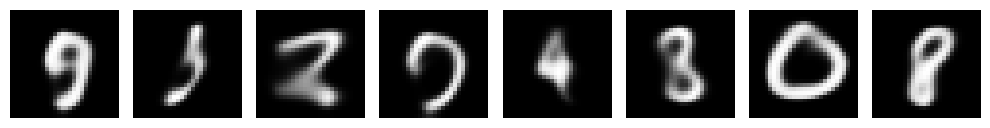

Generated 8 samples
Total parameters (VAE + Flow): 169905


In [23]:
# Generate samples
n_samples = 8
n_steps = 15

# Move models back to device if needed
vae = vae.to(device)
flow_model = flow_model.to(device)

with torch.no_grad():
    with ema_flow.average_parameters():
        # Start from noise
        z_noise = torch.randn(n_samples, 16, device=device)

        # Integrate through flow to get latents
        z_samples = integrate_path(flow_model, z_noise, step_fn=rk4_step, n_steps=n_steps, latent_2d=False)

    with ema.average_parameters():
        # Decode latents to images
        x_samples = vae.decoder(z_samples)
        x_samples = torch.sigmoid(x_samples)
        x_samples = x_samples.cpu()

# Plot
fig, axes = plt.subplots(1, 8, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_samples[i, 0], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.savefig('generated_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Generated {n_samples} samples")
print("Total parameters (VAE + Flow):", sum(p.numel() for p in vae.parameters()) + sum(p.numel() for p in flow_model.parameters()))

## Submission Interface Class

The following class is used for automated evaluation and can load models from Google Drive links.

In [ ]:
!pip install gdown

import gdown

class SubmissionInterface(nn.Module):
    """All teams must implement this for automated evaluation.
    When you subclass/implement these methods, replace the NotImplementedError."""

    def __init__(self):
        super().__init__()

        # --- REQUIRED INFO:
        self.info = {
            'team': 'marco',
            'names': 'Marco',
        }
        self.latent_dim = 16
        self.specifications = {
            "latent_shape": (16,),
            "base_channels": 16,
            "blocks_per_level": 2,
            "groups": 4,
            "dropout": 0.3,
            "act": nn.GELU,
            "use_skips": True,
            "use_bn": True
        }
        # ----

        # keep support for full auto-initialization:
        self.device = 'cpu'
        self.load_vae()
        self.load_flow_model()

    def load_vae(self):
        """this completely specifies the vae model including configuration parameters,
            downloads/mounts the weights from Google Drive, automatically loads weights"""
        self.vae = InspoResNetVAE(**self.specifications)
        vae_weights_file = 'downloaded_vae.safetensors'
        safetensors_link = "https://drive.google.com/file/d/1rP6yP5yixCI1M7LOrv9v9vJkeYkXnptG/view?usp=drive_link"
        gdown.download(safetensors_link, vae_weights_file, quiet=False, fuzzy=True)
        self.vae.load_state_dict(load_file(vae_weights_file))

    def load_flow_model(self):
        """this completely specifies the flow model including configuration parameters,
           downloads/mounts the weights from Google Drive, automatically loads weights"""
        self.flow_model = FlatVelocityNet(input_dim=self.latent_dim)
        flow_weights_file = 'downloaded_flow.safetensors'
        safetensors_link = "https://drive.google.com/file/d/1pAU4p6xQMDgAuywu-go-5iM4qPDXgJFc/view?usp=drive_link"
        gdown.download(safetensors_link, flow_weights_file, quiet=False, fuzzy=True)
        self.flow_model.load_state_dict(load_file(flow_weights_file))

    def generate_samples(self, n_samples: int, n_steps=15) -> torch.Tensor:
        z0 = torch.randn([n_samples, self.latent_dim]).to(self.device)
        z1 = integrate_path(self.flow_model, z0, n_steps=n_steps, step_fn=rk4_step)
        gen_xhat = F.sigmoid(self.decode(z1).view(-1, 28, 28))
        return gen_xhat

    def encode(self, images: torch.Tensor) -> torch.Tensor:
        # if your vae has linear layers, flatten first
        # if your vae has conv layers, comment out next line
        # images = images.view(images.size(0), -1)
        with torch.no_grad():
            z = self.vae.encoder(images.to(self.device))
            # mu = z[:, :self.latent_dim]  # return only first half (mu)
            if isinstance(z, (tuple, list)):
                mu, _ = z
            else:
                mu = z
            return mu

    def decode(self, latents: torch.Tensor) -> torch.Tensor:
        return self.vae.decoder(latents)

    def to(self, device):
        self.device = device
        self.vae.to(self.device)
        self.flow_model.to(self.device)
        return self

# Sample usage:
# device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
# mysub = SubmissionInterface().to(device) # loads vae and flow models
# xhat_gen = mysub.generate_samples(n_samples=10, n_steps=100)